# Work on the Jaccard distance for the plausibility problem

In [1]:
%load_ext autoreload
%autoreload 2

import os
from os import path
# set the repository to the git repository
cwd = os.getcwd().split(os.path.sep)
while cwd[-1] != "stage_4_gm":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
print(">> the git rep : ", end="")
print(os.getcwd())

# the folder where we will save our data
plots_folder = os.path.join(os.getcwd(), '.cache', 'plots')
graph_folder = path.join(plots_folder, "jaccard_map")
if not path.exists(path.join(plots_folder, "jaccard_map")):
    os.mkdir(path.join(plots_folder, "jaccard_map"))

print(f">> the plots location : {graph_folder}")

>> the git rep : C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm
>> the plots location : C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm\.cache\plots\jaccard_map


In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
import sklearn.metrics as metrics
import random

from training_bert import BertNliLight
from custom_data_set import SnliDataset
from custom_data_set import test_dir, dev_dir
from torch.utils.data import DataLoader
import pickle

# --> from this environment
from attention_algorithms.raw_attention import RawAttention
from attention_algorithms.attention_metrics import normalize_attention
from attention_algorithms.attention_metrics import default_plot_colormap
from attention_algorithms.attention_metrics import attention_score

# --> display HTML outputs
from attention_algorithms.plausibility_visu import construct_html_table
from attention_algorithms.plausibility_visu import hightlight_txt
from IPython.display import display, HTML
from ipywidgets import interact_manual

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ckp = path.join(".cache", "logs", "igrida_trained", "0", "best.ckpt")
model = BertNliLight.load_from_checkpoint(ckp)
model = model.eval()  # make sure to have the model in eval mod before using it

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# load the data
data_set = SnliDataset(dir=test_dir, nb_sentences=1000, msg=False, keep_neutral=False)
data_loader = DataLoader(data_set, batch_size=1000, shuffle=False)

sentences, masks, train_labels = next(iter(data_loader))

In [5]:
# the data we annotated.
e_snli_data = pd.read_csv(os.path.join('.cache', 'raw_data', 'e_snli', 'cleaned_data', 'test.csv'), sep=",")\
    [["tok_sent", "hg_goal", "label"]]
e_snli_data.head()

,tok_sent,hg_goal,label
0,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",neutral
1,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",entailment
2,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",contradiction
3,"['[CLS]', 'a', 'woman', 'with', 'a', 'green', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",neutral
4,"['[CLS]', 'a', 'woman', 'with', 'a', 'green', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",entailment


In [6]:
pur_attention, Y_test = None, None
auc_path = graph_folder = path.join(plots_folder, "auc_head_map")
dir = os.path.join(auc_path, "inference_dict.pickle")

if os.path.exists(dir) and os.path.getsize(dir) != 0:
    print(">> the files already exist in the environment >> loading the files ...", end="")
    with open(os.path.join(plots_folder, "inference_dict.pickle"), "rb") as f:
        pur_attention, Y_test = pickle.load(f)
    print(" loading finished")
else :
    with open(os.path.join(os.path.join(plots_folder,"inference_dict.pickle")), "wb") as f:
        pur_attention, Y_test, _ = attention_score(sentences=sentences, masks=masks,
                                                   e_snli_data=e_snli_data,
                                                   model=model, TR_q=0,
                                                   quantiles_calc=False)

        pickle.dump([pur_attention, Y_test], f)

>> the files already exist in the environment >> loading the files ... loading finished


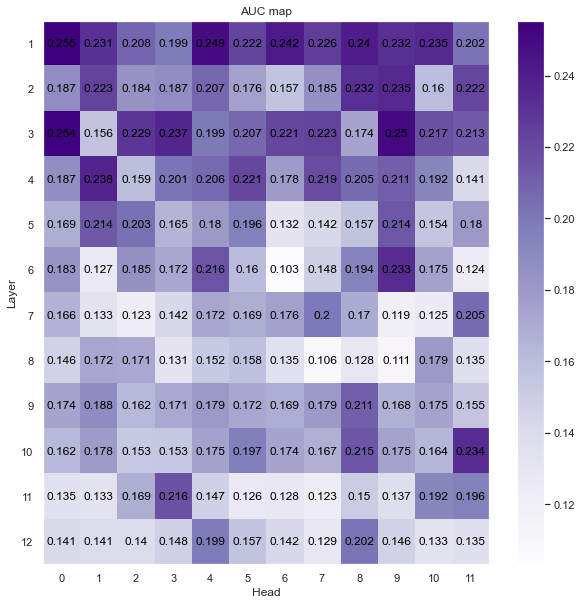

In [7]:
# Construction of the jaccard map
Y_test = np.array(Y_test, dtype=float)
jaccard_map = np.zeros((12, 12))
for l in range(12):
    for h in range(12):
        preds = np.array(pur_attention[f"layer_{l}"][f"head_{h}"])
        jaccard_map[l, h] = np.dot(Y_test, preds)/(np.sum(Y_test) + np.sum(preds) - np.dot(Y_test, preds))

# plot the color map
fig = default_plot_colormap(jaccard_map, xlabel="Head", ylabel="Layer", title="AUC map")
plt.savefig(os.path.join(graph_folder, "jaccard_map.png"))
plt.show()

The Jaccard distance allow us to acces an information really important, which wasn't allowed with the AUC problem. Now we have a criterion to discriminate the bad heads.

In [8]:
pos_min = np.unravel_index(np.argmin(jaccard_map, axis=None), jaccard_map.shape)
print(f">> the head : {pos_min[0]+1}, {pos_min[1]} has the worst jaccard distance")

pos_max = np.unravel_index(np.argmax(jaccard_map, axis=None), jaccard_map.shape)
print(f">> the head : {pos_max[0]+1}, {pos_max[1]} has the best jaccard distance")

>> the head : 6, 6 has the worst jaccard distance
>> the head : 1, 0 has the best jaccard distance


In [9]:
sent_choice = [random.randint(0, 1000) for _ in range(4)]
print(f">> we will look at the sentence : {sent_choice}")

>> we will look at the sentence : [967, 688, 50, 587]


In [10]:
# This time we will keep the specials tokens to see what will happen
annot = []

for k in sent_choice:
    buff_dict = {}
    sent = sentences[k, :].clone().detach()[None, :]
    mk = masks[k, :].clone().detach()[None, :]
    raw_attention_inst = RawAttention(model=model,
                                      input_ids=sent,
                                      attention_mask=mk,
                                      test_mod=False
                                      )

    # we will now earch the e-snli corresponding sentence
    j = 0

    while eval(e_snli_data["tok_sent"][j]) != raw_attention_inst.tokens:
        j += 1

    buff_dict["annotation"] = hightlight_txt(raw_attention_inst.tokens,
                                             torch.tensor(eval(e_snli_data.hg_goal[j])))

    # construction of the attention score
    attention_score = raw_attention_inst.attention_tensor[0, pos_min[0], pos_min[1], :, :].sum(dim=0)
    # noramlization of the score
    attention_score = normalize_attention(tokens=raw_attention_inst.tokens,
                                         attention=attention_score)

    buff_dict[f"head {pos_min}"] = hightlight_txt(attention=attention_score,
                                              tokens=raw_attention_inst.tokens)
    
    # the bad head
    attention_score = raw_attention_inst.attention_tensor[0, pos_max[0], pos_max[1], :, :].sum(dim=0)
    # normalization of the score
    attention_score = attention_score = normalize_attention(tokens=raw_attention_inst.tokens,
                                         attention=attention_score)

    buff_dict[f"head {pos_max}"] = hightlight_txt(attention=attention_score,
                                             tokens=raw_attention_inst.tokens)
    
    annot.append(buff_dict)

display(HTML(construct_html_table(annot[0].keys(), annot)))

annotation,"head (5, 6)","head (0, 0)"
[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP],[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP],[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP]
[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP],[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP],[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP]
[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP],[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP],[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP]
[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP],[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP],[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP]


In [11]:
# This time we will keep the specials tokens to see what will happen
annot = []

for k in sent_choice:
    buff_dict = {}
    sent = sentences[k, :].clone().detach()[None, :]
    mk = masks[k, :].clone().detach()[None, :]
    raw_attention_inst = RawAttention(model=model,
                                      input_ids=sent,
                                      attention_mask=mk,
                                      test_mod=False
                                      )

    # we will now earch the e-snli corresponding sentence
    j = 0

    while eval(e_snli_data["tok_sent"][j]) != raw_attention_inst.tokens:
        j += 1

    buff_dict["annotation"] = hightlight_txt(raw_attention_inst.tokens,
                                             torch.tensor(eval(e_snli_data.hg_goal[j])))

    # construction of the attention score
    attention_score = raw_attention_inst.attention_tensor[0, pos_min[0], pos_min[1], :, :].sum(dim=0)
    # noramlization of the score
    attention_score = np.array((attention_score - attention_score.min())/(attention_score.max() - attention_score.min()))

    buff_dict[f"head {pos_min}"] = hightlight_txt(attention=attention_score,
                                              tokens=raw_attention_inst.tokens)
    
    # the bad head
    attention_score = raw_attention_inst.attention_tensor[0, pos_max[0], pos_max[1], :, :].sum(dim=0)
    # normalization of the score
    attention_score = np.array((attention_score - attention_score.min())/(attention_score.max() - attention_score.min()))

    buff_dict[f"head {pos_max}"] = hightlight_txt(attention=attention_score,
                                             tokens=raw_attention_inst.tokens)
    annot.append(buff_dict)

display(HTML(construct_html_table(annot[0].keys(), annot)))

annotation,"head (5, 6)","head (0, 0)"
[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP],[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP],[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP]
[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP],[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP],[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP]
[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP],[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP],[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP]
[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP],[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP],[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP]


In [12]:
# This time we will keep the specials tokens to see what will happen
for layer in range(12):
    annot = []
    idx = np.argmax(jaccard_map[layer, :])
    print(f">>layer {layer} >> jaccard head {idx}")
    for k in sent_choice:
        buff_dict = {}
        sent = sentences[k, :].clone().detach()[None, :]
        mk = masks[k, :].clone().detach()[None, :]
        raw_attention_inst = RawAttention(model=model,
                                          input_ids=sent,
                                          attention_mask=mk,
                                          test_mod=False
                                          )

        # we will now earch the e-snli corresponding sentence
        j = 0

        while eval(e_snli_data["tok_sent"][j]) != raw_attention_inst.tokens:
            j += 1

        buff_dict["annotation"] = hightlight_txt(raw_attention_inst.tokens,
                                                 torch.tensor(eval(e_snli_data.hg_goal[j])))
        
        attention_score = raw_attention_inst.attention_tensor[0, layer, idx, :, :].sum(dim=0)
        
        # noramlization of the score
        attention_score = np.array((attention_score - attention_score.min())/(attention_score.max() - attention_score.min()))

        buff_dict[f"layer {layer}"] = hightlight_txt(attention=attention_score,
                                                  tokens=raw_attention_inst.tokens)

        annot.append(buff_dict)

    display(HTML(construct_html_table(annot[0].keys(), annot)))

>>layer 0 >> jaccard head 0


annotation,layer 0
[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP],[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP]
[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP],[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP]
[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP],[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP]
[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP],[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP]


>>layer 1 >> jaccard head 9


annotation,layer 1
[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP],[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP]
[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP],[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP]
[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP],[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP]
[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP],[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP]


>>layer 2 >> jaccard head 0


annotation,layer 2
[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP],[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP]
[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP],[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP]
[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP],[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP]
[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP],[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP]


>>layer 3 >> jaccard head 1


annotation,layer 3
[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP],[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP]
[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP],[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP]
[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP],[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP]
[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP],[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP]


>>layer 4 >> jaccard head 9


annotation,layer 4
[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP],[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP]
[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP],[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP]
[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP],[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP]
[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP],[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP]


>>layer 5 >> jaccard head 9


annotation,layer 5
[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP],[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP]
[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP],[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP]
[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP],[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP]
[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP],[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP]


>>layer 6 >> jaccard head 11


annotation,layer 6
[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP],[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP]
[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP],[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP]
[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP],[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP]
[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP],[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP]


>>layer 7 >> jaccard head 10


annotation,layer 7
[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP],[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP]
[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP],[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP]
[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP],[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP]
[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP],[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP]


>>layer 8 >> jaccard head 8


annotation,layer 8
[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP],[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP]
[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP],[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP]
[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP],[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP]
[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP],[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP]


>>layer 9 >> jaccard head 11


annotation,layer 9
[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP],[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP]
[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP],[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP]
[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP],[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP]
[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP],[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP]


>>layer 10 >> jaccard head 3


annotation,layer 10
[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP],[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP]
[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP],[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP]
[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP],[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP]
[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP],[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP]


>>layer 11 >> jaccard head 8


annotation,layer 11
[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP],[CLS] a man in a black business suit stands upright next to a man wearing blue and leaning against a railing . [SEP] a man in a black suit is standing next to a man in a blue outfit . [SEP]
[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP],[CLS] two dogs fighting over a pink and red toy [SEP] the dogs are eating from their dog bowls . [SEP]
[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP],[CLS] a man in a black shirt is looking at a bike in a workshop . [SEP] a man is wearing a red shirt [SEP]
[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP],[CLS] dog running with pet toy being chased by another dog . [SEP] dog is running and being chased by another dog [SEP]
